This notebook is about how I tuned the parameters for XGBoost.

In [183]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

### Data Manipulation

In [185]:
# Import data
train_df = pd.read_csv("train_data_clean2.csv")
test_df = pd.read_csv("test_data_clean2.csv")

# Encode gender and living status and state
train_df["living_status"] = pd.Categorical(train_df["living_status"])
train_df["gender"] = np.where(train_df["gender"].str.contains("M"), 1, 0)
train_df["living_status"] = np.where(train_df["living_status"].str.contains("Rent"), 1, 0)

test_df["living_status"] = pd.Categorical(test_df["living_status"])
test_df["gender"] = np.where(test_df["gender"].str.contains("M"), 1, 0)
test_df["living_status"] = np.where(test_df["living_status"].str.contains("Rent"), 1, 0)

# one-hot encoding for site of state
state_dummies = pd.get_dummies(test_df['state'], 
                                  prefix='state', drop_first=True)
test_df = pd.concat([test_df, state_dummies], axis=1)
test_df.drop(["state"], axis=1, inplace=True)

# one-hot encoding for site of state
state_dummies = pd.get_dummies(train_df['state'], 
                                  prefix='state', drop_first=True)
train_df = pd.concat([train_df, state_dummies], axis=1)
train_df.drop(["state"], axis=1, inplace=True)

# Drop month, day and year data
train_df.drop(["claim_month_january", "claim_month_february", "claim_month_march", "claim_month_may", 
              "claim_month_june", "claim_month_july", "claim_month_august", "claim_month_september", 
              "claim_month_october", "claim_month_november", "claim_month_december", 
              "claim_day_monday", "claim_day_tuesday", "claim_day_wednesday", "claim_day_thursday", 
               "claim_day_saturday", "claim_day_sunday", "claim_year", "claim_day", 
              "zip_code", "claim_date", "claim_number", 'SP_Index', "vehicle_color_blue", 
               "vehicle_color_gray", "vehicle_color_other", "vehicle_color_red", 
              "vehicle_color_silver", "vehicle_color_white"], axis =1, inplace=True)

test_df.drop(["claim_month_january", "claim_month_february", "claim_month_march", "claim_month_may", 
              "claim_month_june", "claim_month_july", "claim_month_august", "claim_month_september", 
              "claim_month_october", "claim_month_november", "claim_month_december", 
              "claim_day_monday", "claim_day_tuesday", "claim_day_wednesday", "claim_day_thursday", 
               "claim_day_saturday", "claim_day_sunday", "claim_year", "claim_day", 
              "zip_code", "claim_date", "claim_number", 'SP_Index', "vehicle_color_blue", 
               "vehicle_color_gray", "vehicle_color_other", "vehicle_color_red", 
              "vehicle_color_silver", "vehicle_color_white"], axis =1, inplace=True)

### AUC metric

In [99]:
# Seperate the training data into training data and validation data
y = train_df["fraud"]
X = train_df.drop("fraud", 1)
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

### consider unemployment rate
y_pred_xgb = model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc(fpr_xgb, tpr_xgb)

### Parameter tuning

In [59]:
parameters = {
              'max_depth': [4, 8, 12, 16, 20],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'n_estimators': [300, 600, 900, 1200, 1500],
              'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [0, 0.2, 0.6, 1, 2],
              'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
              'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
              'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]
}

xlf = xgb.XGBClassifier(max_depth=10,
            learning_rate=0.01,
            n_estimators=300,
            silent=True,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)


### Step1: Set learning rate=0.1, tuning n_estimator

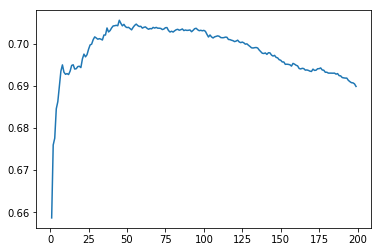

In [180]:
auc_xgb = list()
for i in np.arange(1, 200):
    n_estimator = i
    clf = xgb.XGBClassifier(
            max_depth=6,
            learning_rate=0.1,
            n_estimators=n_estimator,
            silent=True,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)
    model_sklearn = clf.fit(X_train, y_train)
    y_pred_xgb = clf.predict_proba(X_test)[:,1]
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
    auc_xgb.append(auc(fpr_xgb, tpr_xgb))
plt.plot(np.arange(1, 200), auc_xgb)
plt.show()

This plot seems like wierd.

In [87]:
parameters = {
              'n_estimators': [50, 75, 100] 
}

xlf = xgb.XGBClassifier(max_depth=6,
            learning_rate=0.1,
            n_estimators=100,
            silent=True,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.701
Best parameters set:
	n_estimators: 50


In [114]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
clf.fit(X_train, y_train)
y_pred_xgb = clf.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc(fpr_xgb, tpr_xgb)

0.716093270014821

choose n_estimator = 80

### Step2: max_depth and min_child_weight

In [116]:
parameters = {
              'max_depth': range(3, 10, 2),
              'min_child_weight': range(1, 6, 2)
}

xlf = xgb.XGBClassifier(max_depth=5,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	max_depth: 3
	min_child_weight: 5


In [117]:
parameters = {
              'max_depth': [2, 3, 4],
              'min_child_weight': [4, 5, 6]
}

xlf = xgb.XGBClassifier(max_depth=5,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	max_depth: 3
	min_child_weight: 5


Set max_depth = 3, min_child_weight = 5

### Step3: gamma

In [118]:
parameters = {
              'gamma':[i/10.0 for i in range(0,5)]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	gamma: 0.0


Set gamma = 0

### Step4: subsample and colsample_bytree

In [119]:
parameters = {
              'subsample':[i/10.0 for i in range(6,10)],
              'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	colsample_bytree: 0.8
	subsample: 0.8


In [120]:
parameters = {
              'subsample':[i/100.0 for i in range(75, 90, 5)],
              'colsample_bytree':[i/100.0 for i in range(75, 90, 5)]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	colsample_bytree: 0.8
	subsample: 0.8


Set colsample_bytree = 0.8, subsample = 0.8

### Step5: reg_alpha and reg_lambda

In [122]:
parameters = {
              'reg_alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	reg_alpha: 1e-06


Set reg_alpha = 0

In [123]:
parameters = {
              'reg_lambda': [0.1, 0.5, 1, 1.5, 2]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	reg_lambda: 1


In [124]:
parameters = {
              'reg_lambda': [0.6, 0.8, 1, 1.2, 1.4]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	reg_lambda: 1


Set reg_lambda = 1

### Step6: lower down learning_rate

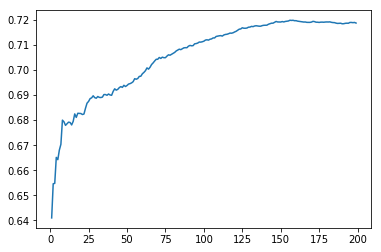

In [130]:
auc_xgb = list()
for i in np.arange(1, 200):
    n_estimator = i
    clf = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.05,
            n_estimators=n_estimator,
            silent=True,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)
    model_sklearn = clf.fit(X_train, y_train)
    y_pred_xgb = clf.predict_proba(X_test)[:,1]
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
    auc_xgb.append(auc(fpr_xgb, tpr_xgb))

plt.plot(np.arange(1, 200), auc_xgb)
plt.show()

In [135]:
clf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.05,
            n_estimators=160,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)
clf.fit(X_train, y_train)
y_pred_xgb = clf.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc(fpr_xgb, tpr_xgb)

0.7197219900201546

Set learning_rate = 0.05, n_estimator = 160

Repeat the steps again.

In [140]:
# Step2: max_depth and min_child_weight
parameters = {
              'max_depth': [2, 3, 4],
              'min_child_weight': [4, 5, 6]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.05,
            n_estimators=160,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	max_depth: 3
	min_child_weight: 5


Set max_depth = 3,min_child_weight = 5

In [146]:
# Step3: gamma
parameters = {
              'gamma':[0.27, 0.285, 0.3, 0.315, 0.33]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.05,
            n_estimators=160,
            silent=True,
            objective='binary:logistic',
            gamma=0,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	gamma: 0.3


Set gamma = 0.3

In [153]:
# Step4: subsample and colsample
parameters = {
              'subsample':[0.78, 0.8, 0.82],
              'colsample_bytree':[0.78, 0.79, 0.8]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.1,
            n_estimators=80,
            silent=True,
            objective='binary:logistic',
            gamma=0.3,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.8,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	colsample_bytree: 0.78


Set subsample = 0.8, set colsample_bytree = 0.8 or 0.78.

colsample_bytree = 0.8: higher results in test, 0.78 is recommended by CV.
Set it to be 0.785

In [158]:
# Step5: reg_alpha and reg_lambda
parameters = {
              'reg_alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.05,
            n_estimators=160,
            silent=True,
            objective='binary:logistic',
            gamma=0.3,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.785,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	reg_alpha: 0.01


Set reg_alpha = 0.01

In [181]:
# Step5: reg_alpha and reg_lambda
parameters = {
              'reg_lambda': [0.5, 0.8, 1, 1.2, 1.5]
}

xlf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.05,
            n_estimators=160,
            silent=True,
            objective='binary:logistic',
            gamma=0.3,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.785,
            colsample_bylevel=1,
            reg_alpha=0.01,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	reg_lambda: 1


Set reg_lambda = 1

So, the final set of parameters are as follows.

In [179]:
clf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.05,
            n_estimators=160,
            silent=True,
            objective='binary:logistic',
            gamma=0.3,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.785,
            colsample_bylevel=1,
            reg_alpha=0.01,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=None,
            missing=None)
clf.fit(X_train, y_train)
y_pred_xgb = clf.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc(fpr_xgb, tpr_xgb)

0.7162731482668607